In [1]:
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from pathlib import Path

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

2023-01-29 01:37:34,575 - Wrapper - INFO - Running elastix in: ../output/1674952654_learn_1_adaptivestochasticgradientdescent_573984
2023-01-29 01:37:36,787 - Validation - INFO - Calculating validation metrics for LEARN:
2023-01-29 01:37:36,788 - Validation - INFO - TRE: 18.563463102859906
2023-01-29 01:37:40,171 - Validation - INFO - Validation metrics calculated in 3.38s
2023-01-29 01:37:40,172 - Wrapper - INFO - Run ended. It took 5.5965 seconds


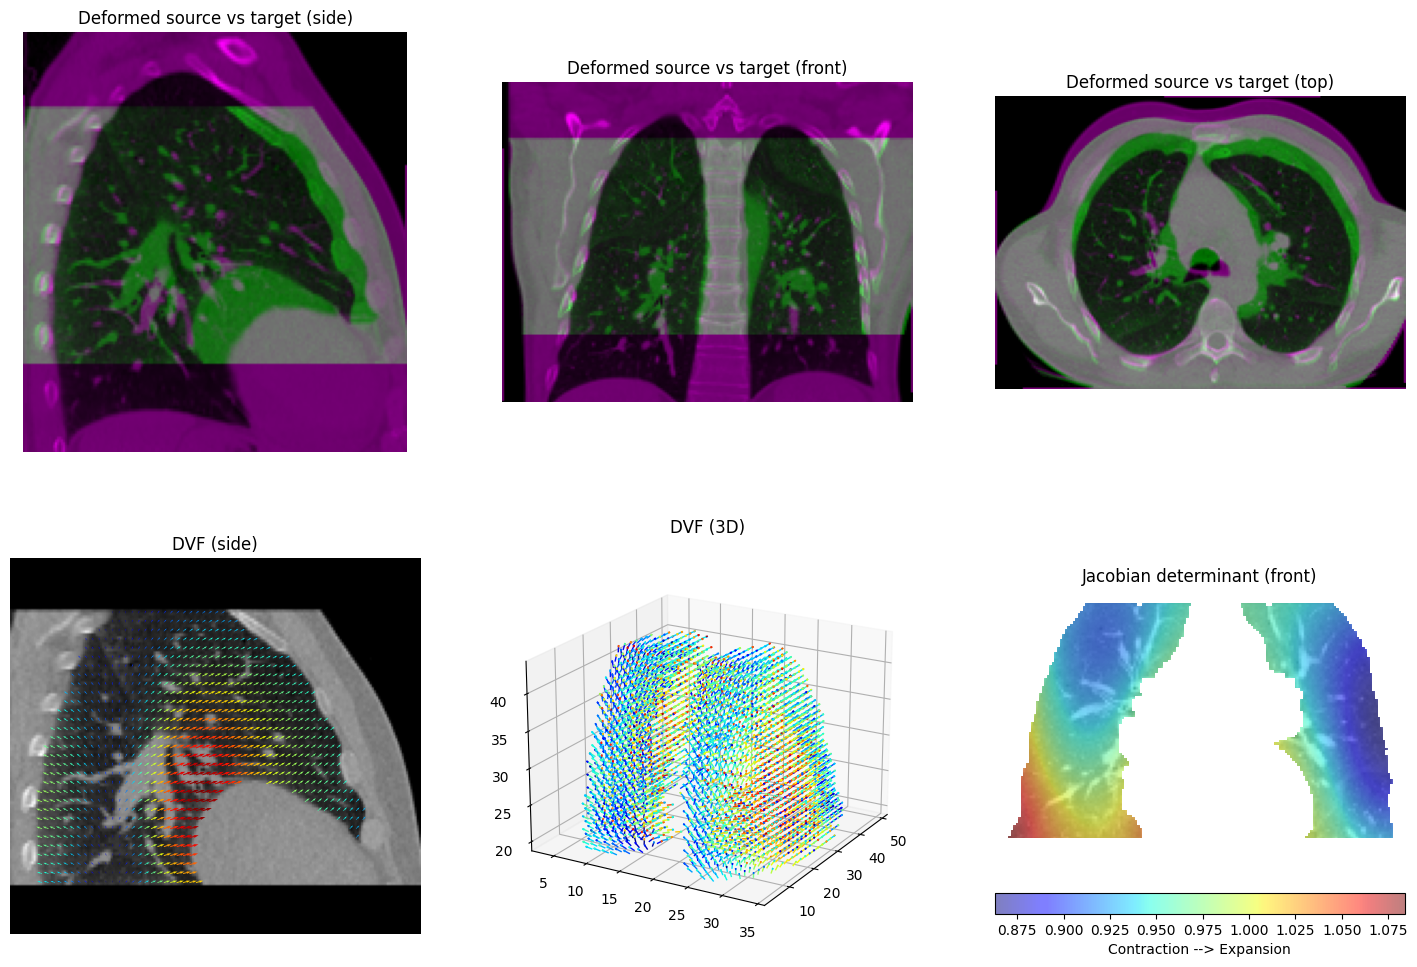

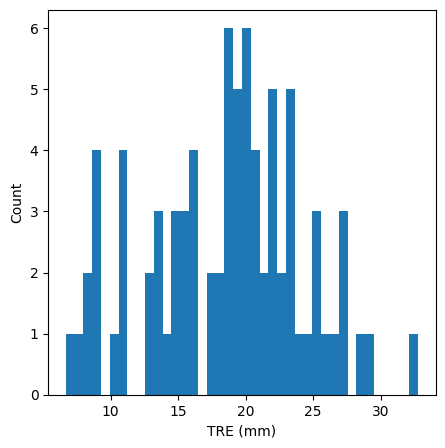

In [2]:
params = (
    Parameters.from_base(mesh_size=5, metric="AdvancedNormalizedCorrelation", seed=1, use_mask=True)
    .asgd()
    .multi_resolution(1, p_sched=[3], downsampling=True)
    .stopping_criteria(20)
    .instance(Collection.LEARN, 1)
)
run_result = run(params, Path("../output/" + str(params)), suppress_stdout=True, visualize=False, validate=True)